In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib import pyplot
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')


In [2]:
def getAllRateInfo(path):
    res=pd.DataFrame()
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CPSM_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CH60_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'FAS_MOUSE.' in x  ]
    for f in tqdm(files):
        try:
            temp=pd.read_csv(os.path.join(path,f))
            temp=temp.dropna()
            temp['Protein']=f.replace('.RateConst.csv','')
            res=pd.concat([res,temp])
        except Exception as exp:
            print(f,exp)
    res.columns=[x.strip() for x in res.columns]
    return res
def read_n_merge(orignial_data,skip,file,folder_path):
    file_data=pd.read_csv(os.path.join(folder_path,file),skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.replace('.Quant.csv','')
        orignial_data=pd.concat([orignial_data,file_data])       
    return [isparsed,orignial_data]

def get_df_all_quant_files(path):
    files=[x for x in os.listdir(path) if '.Quant.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'CPSM_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'CH60_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'FAS_MOUSE.Quant.csv' in x  ]      
    all_data=pd.DataFrame()  
        
    for index in tqdm(range(len(files))):            
        res=read_n_merge(all_data,1,files[index],path)
        # print(res)
        if res[0]:
            all_data=res[1]
        else:
            all_data=read_n_merge(all_data,3,files[index],path)[1]
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

In [3]:
BW = [0, 0.0386, 0.0448, 0.0458, 0.046, 0.046, 0.046, 0.046, 0.046, 0.046, 0.046, 0.046]
allTime = [0, 1, 2, 3, 6, 7, 9, 13, 16, 21, 24, 31]
ph=1.5574E-4


def get_I0_t(time,data,index):
    index_t=allTime.index(time)
    suffix="" if index_t==0 else f".{index_t}"
    total=0
    for i in range(6):
        try:total+= int(data.loc[index,f"I{i}{suffix}"])
        except: continue
    
    ria=None
    
    if total!=0: 
        try:
            ria=int(data.loc[index,f"I0{suffix}"])/total
        except: ria=None
        
    return ria

In [4]:
path=r"\\UT321319\Shared_Folder\NEH_Dependence\liverpool_liver"

In [5]:
quant=get_df_all_quant_files(path)
rate=getAllRateInfo(path)

100%|██████████| 2010/2010 [01:35<00:00, 21.05it/s]


In [84]:
merged=pd.merge(quant,rate,left_on=['Peptide','Charge'],right_on=['Peptides','Charge'])
merged=merged[merged['Rsquared']>0.99].reset_index(drop=True)
merged=merged.reset_index(drop=True)
merged.shape

(983, 220)

In [85]:
error,error_rd,abudance=[],[],[]
for index in tqdm(range(merged.shape[0])):
    M0=merged.loc[index,'M0']/100
    I0_0_exp=get_I0_t(0,merged,index)
    if I0_0_exp == None: continue
    
    ionScore=merged.loc[index,'IonScore']
    if ionScore < 15: continue
    
    
    A0_exp=merged.loc[index,'I0']/100 
    error.append( (I0_0_exp - M0)  )  
    error_rd.append( (I0_0_exp - M0)/M0  )       
    abudance.append(A0_exp) 

  0%|          | 0/983 [00:00<?, ?it/s]

100%|██████████| 983/983 [00:01<00:00, 691.71it/s]


Text(0, 0.5, '$\\frac{ I_0(0)^{exp} - I_0(0)^{theo} }{I_0(0)^{theo}}$')

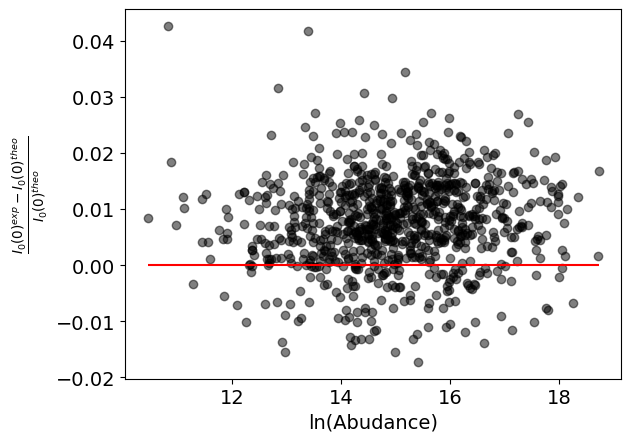

In [86]:
log_abudance=[math.log(x) for x in abudance]


plt.rc('font',size=14)
plt.scatter(log_abudance,error,c='k',alpha=0.5)
plt.hlines(y=0,xmin= min(log_abudance),xmax=max(log_abudance),colors='red')
plt.xlabel("ln(Abudance)")
plt.ylabel(r"$\frac{ I_0(0)^{exp} - I_0(0)^{theo} }{I_0(0)^{theo}}$")

In [87]:
def tempfn(k=0.11,t=6):
    return 1 - math.exp(-k*t)

In [88]:
# plt.plot(range(15),[tempfn(t=t) for t in range(15)])

In [89]:
import numpy as np

def computefsr(p_W, p_H, delta_A_10_t, N_EH):
    """
    Computes the expression:
    1 - e^(-kt) = numerator / denominator
    """
    ratio = (1 - p_W) / (1 - p_H)
    ratio_power = ratio ** N_EH

    numerator = (1 - p_W) * (1 - p_H) * delta_A_10_t
    denominator = (
        (1 - p_W) * (1 - p_H) * delta_A_10_t * (1 - ratio_power)
        + ratio_power * N_EH * (p_W - p_H)
    )

    return numerator / denominator


In [90]:
# computefsr(p_W,p_H,delta_A_10_t,N_EH)

In [91]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 1. Theoretical isotope distribution (example)
# mz_values = np.array([100, 101, 102, 103])
# theoretical_intensities = np.array([100, 10, 1, 0.1]) # M0, M1, M2, M3

# # 2. Define SNR levels to simulate
# snr_levels_linear = [2, 5, 10, 20, 50]

# plt.figure(figsize=(12, 8))

# for i, snr_linear in enumerate(snr_levels_linear):
#     # 3. Add noise
#     signal_amplitude = theoretical_intensities[0] # Using M0 peak as reference
#     noise_std = signal_amplitude / snr_linear
#     noisy_intensities = theoretical_intensities + np.random.normal(0, noise_std, len(theoretical_intensities))
#     noisy_intensities[noisy_intensities < 0] = 0 # Ensure intensities are non-negative

#     # 4. Plot the simulated spectrum
#     plt.subplot(len(snr_levels_linear), 1, i + 1)
#     plt.stem(mz_values, noisy_intensities, basefmt=" ")
#     plt.title(f"SNR (Linear) = {snr_linear:.1f}")
#     plt.ylabel("Intensity")
#     if i == len(snr_levels_linear) - 1:
#         plt.xlabel("m/z")

# plt.tight_layout()
# plt.show()

# # 5. (Further analysis would involve quantifying peak detection, intensity errors, etc.)

<Axes: ylabel='Count'>

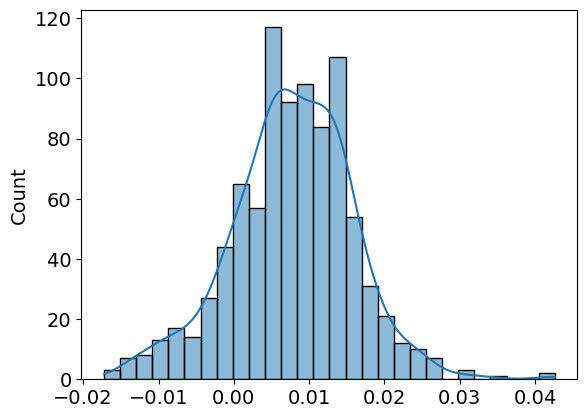

In [92]:
sns.histplot(error,kde=True)

In [93]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [94]:
# plt.hist(error-stats.laplace.fit(error)[0])


Normal
  Parameters: (0.007744510827742353, 0.008071293486088484)
  Log-Likelihood: 3040.050
  AIC: -6076.099
  BIC: -6066.508

Laplace (zero-centered)
  Parameters: (0, 0.009331546672889794)
  Log-Likelihood: 2665.199
  AIC: -5326.399
  BIC: -5316.807

Laplace (non-zero-centered)
  Parameters: (0.007944016223485617, 0.006262487876779792)
  Log-Likelihood: 3021.747
  AIC: -6039.495
  BIC: -6029.903


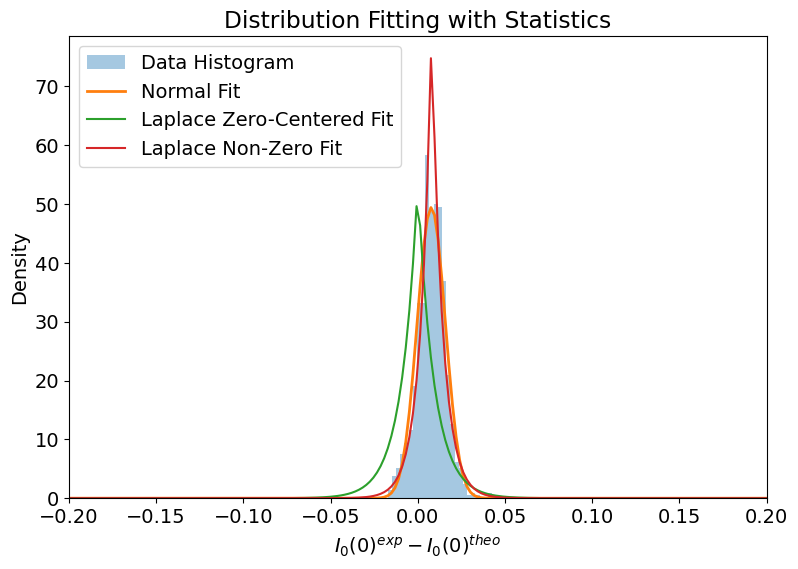

In [95]:
data=error
# data=error-stats.laplace.fit(error)[0]
n=len(error)
def compute_fit_stats(dist_name, dist, params):
    # Compute log-likelihood
    loglik = np.sum(dist.logpdf(data, *params))
    # Number of parameters
    k = len(params)
    # AIC and BIC
    aic = 2 * k - 2 * loglik
    bic = k * np.log(n) - 2 * loglik
    return {
        "distribution": dist_name,
        "params": params,
        "loglik": loglik,
        "AIC": aic,
        "BIC": bic
    }

# 1. Fit Normal Distribution
params_norm = stats.norm.fit(data)
stats_norm = compute_fit_stats("Normal", stats.norm, params_norm)

# 2. Fit Zero-Centered Laplace
params_laplace_zero = stats.laplace.fit(data, floc=0)
stats_laplace_zero = compute_fit_stats("Laplace (zero-centered)", stats.laplace, (0, params_laplace_zero[1]))

# 3. Fit Non-Zero-Centered Laplace
params_laplace = stats.laplace.fit(data)
stats_laplace = compute_fit_stats("Laplace (non-zero-centered)", stats.laplace, params_laplace)

# Print results
for s in [stats_norm, stats_laplace_zero, stats_laplace]:
    print(f"\n{s['distribution']}")
    print(f"  Parameters: {s['params']}")
    print(f"  Log-Likelihood: {s['loglik']:.3f}")
    print(f"  AIC: {s['AIC']:.3f}")
    print(f"  BIC: {s['BIC']:.3f}")



# Plot distributions
plt.figure(figsize=(9,6))
x = np.linspace(min(data)-1, max(data)+1, 1000)
pdf_norm = stats.norm.pdf(x, *params_norm)
pdf_lap_zero = stats.laplace.pdf(x, 0, params_laplace_zero[1])
pdf_lap = stats.laplace.pdf(x, *params_laplace)

plt.hist(data, bins=25, density=True, alpha=0.4,label='Data Histogram')
plt.plot(x, pdf_norm, label='Normal Fit', lw=2)
plt.plot(x, pdf_lap_zero, label='Laplace Zero-Centered Fit')
plt.plot(x, pdf_lap, label='Laplace Non-Zero Fit')
plt.legend()
plt.title('Distribution Fitting with Statistics')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(False)
plt.xlim([-0.2,0.2])

plt.xlabel(r"$I_0(0)^{exp} - I_0(0)^{theo}$")
plt.show()

In [96]:
# np.random.laplace(0.01529133894337914, 0.030093765277856736,len(x))


In [18]:
len(x)

1000

In [19]:
# 0.014260709102941749, 0.013662174608784583